# **MNIST Dataset Notebook** 

- Notebook adapted from:
    - https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
    - https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial
- Goals for this notebook: 
    - Practice using TensorFlow
    - Examine the MNIST dataset
    - Build a Tensorflow model for recognizing the given character from a test set

## **1. Import dataset**

### **1.1. Import modules**

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPool2D, BatchNormalization, GlobalAvgPool2D
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)

2.12.0


### **1.2. Import dataset**

Dataset we are using is MNIST dataset, containing 70000 hand-written digits, being splitted into 60000 for training and 10000 for test set

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Check the shape
print("x_train shape: " + str(x_train.shape))
print("y_train shape: " + str(y_train.shape))
print("x_test shape: " + str(x_test.shape))
print("y_test shape: " + str(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## **2. Plot example data**

### **2.1. Digit distribution**

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64
60000
[5 0 4 ... 5 6 8]


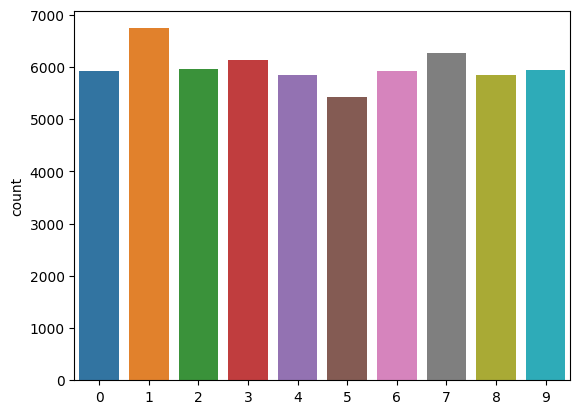

In [28]:
sb.countplot(x=y_train)
print(pd.Series(y_train).value_counts())

plt.show()

The plot showed that the data is distributed relatively even, so we do not need to modify the sample quantity in any way.

### **2.2. Example data points**

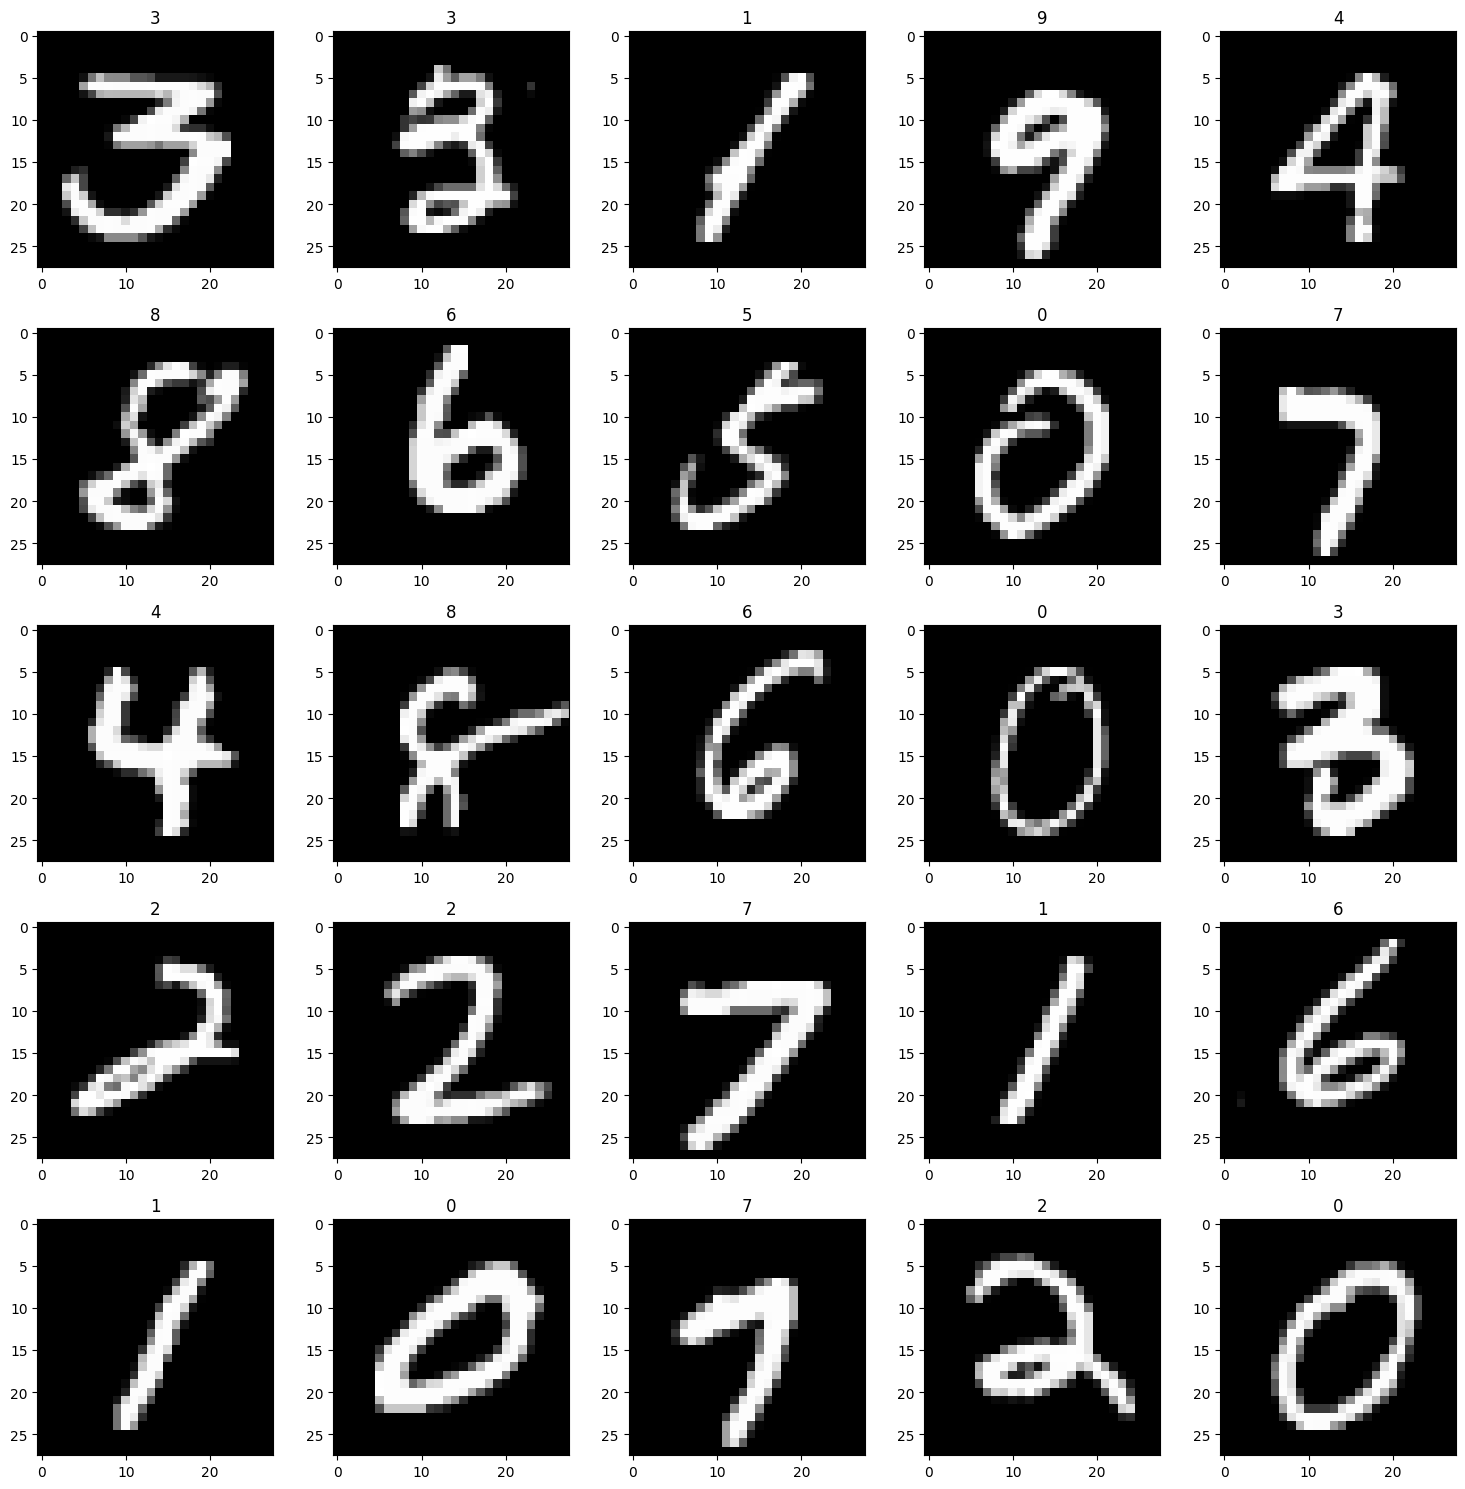

In [3]:
plt.figure(figsize=(15,15))

for i in range(25):
    ind = np.random.randint(0, x_train.shape[0]-1)
    img = x_train[ind]
    label = y_train[ind]
    
    plt.subplot(5,5,i+1)
    plt.title(str(label))
    plt.tight_layout()
    plt.imshow(img, cmap='gray')
    
plt.show()

## **3. Data preprocessing**

Few key things to note:
- The data pixel value is from range 0-255, and model tend to perform better with normalization, so we need to convert to range 0.0-1.0
- The first layer of the CNN expect single 60000x28x28x1 tensor instead of 60000 28x28x1 tensors
- Since current labels are categorical data, it is useful to transform them to continuous data using one-hot encoding

### **3.1. Normalization**

In [4]:
# Data is currently uint8, so we need to convert to float32 for accuracy
x_train = x_train/255.0
y_train = y_train/255.0

### **3.2. Reshaping**

In [29]:
# We need to expand the dimension to (60000, 28, 28, 1) to fit with input of the model
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

### **3.3. Label encoding**

In [30]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

## **4. Modeling**

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=64, epochs=3, validation_split=0.2)

Epoch 1/3
750/750 [==============================] - 160s 213ms/step - loss: 0.3558 - acc: 0.9038 - val_loss: 0.0555 - val_acc: 0.9840
Epoch 2/3
750/750 [==============================] - 162s 216ms/step - loss: 0.1102 - acc: 0.9695 - val_loss: 0.0502 - val_acc: 0.9862
Epoch 3/3
750/750 [==============================] - 161s 215ms/step - loss: 0.0953 - acc: 0.9746 - val_loss: 0.0565 - val_acc: 0.9853


## **5. Model evaluation**

### **5.1. Loss and Accuracy curves**

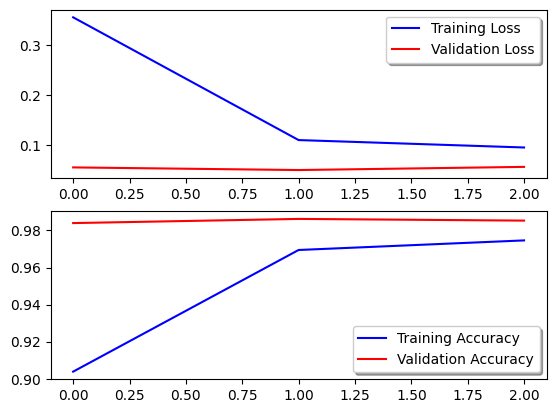

In [41]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### **5.2. Evaluate test set**

In [43]:
test = model.evaluate(x_test, y_test, batch_size=64)

157/157 [==============================] - 7s 47ms/step - loss: 0.0421 - acc: 0.9863


The model worked well with test set with the accuracy of 98.6 percent

### **5.3. Confusion matrix**

Checking error results

313/313 [==============================] - 9s 28ms/step


<AxesSubplot: >

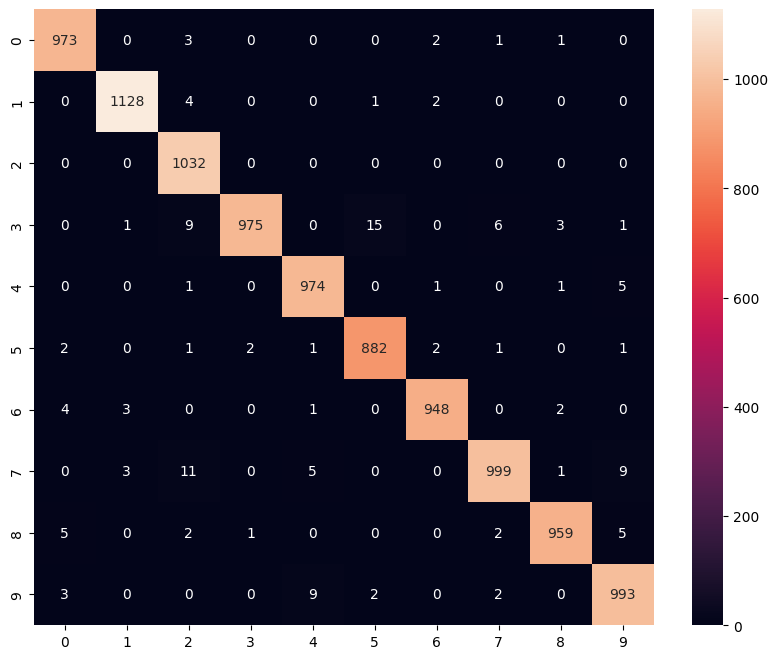

In [45]:
# Predict the values from the testing dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10, 8))
sb.heatmap(confusion_mtx, annot=True, fmt='g')

The confusion matrix showed that the model tend to confuse most between 2 and 7, as well as 3 and 5

### **5.4. Display some error results**

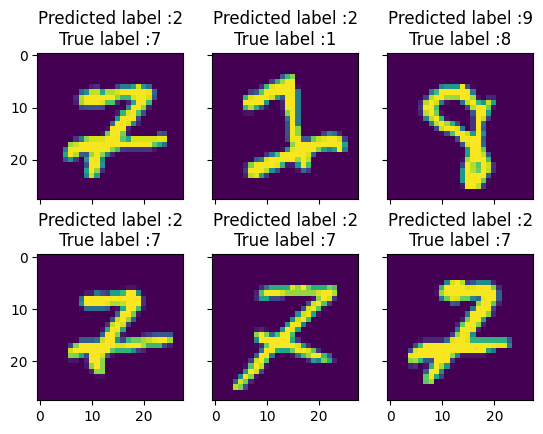

In [47]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)